In [205]:
import pandas as pd
import utils
import glob
import json
import matplotlib.pyplot as plt
import numpy as np

In [212]:
def get_binned_df_list(df, binning_list):
    bin_range = binning_list[-1]
    df_by_chunk = []
    for bin_range in binning_list:
        df_test = df.loc[(df.mean_rating >= bin_range[0]) & (df.mean_rating < bin_range[1])]
        df_by_chunk.append(df_test)
        
    return df_by_chunk


def df_preprocessing(df_list):
    for idx, df in enumerate(df_list):
        df["mean_rating"] = [np.mean(rating) for rating in df.rating]
        df["var_rating"] = [np.var(rating) for rating in df.rating]
        df["numer_of_ratings"] = [len(r) for r in df.rating]
        df = df.loc[df.numer_of_ratings > 2].reset_index(drop=True)
        df_list[idx] = df
    return df_list

In [213]:
df_20 = pd.read_pickle("./data/ICLR2020/ICLR2020_preprocessed_table.pkl")
df_19 = pd.read_pickle("./data/ICLR2019/ICLR2019_preprocessed_table.pkl")
df_18 = pd.read_pickle("./data/ICLR2018/ICLR2018_preprocessed_table.pkl")
df_17 = pd.read_pickle("./data/ICLR2017/ICLR2017_preprocessed_table.pkl")
dfs = [df_17, df_18, df_19, df_20]
names = ["2017", "2018", "2019", "2020"]

# calculating var&mean ratings, removing papers w/ num of ratings <= 2
dfs = df_preprocessing(dfs)


dfs[0].head()

,decision,title,authors,rating,citations,mean_rating,var_rating,numer_of_ratings
0,Accept (Poster),Outrageously Large Neural Networks: The Spars...,"[Noam Shazeer, *Azalia Mirhoseini, *Krzysztof ...","[7, 6, 7]",870.0,6.666667,0.222222,3
1,Invite to Workshop Track,Charged Point Normalization: An Efficient Solu...,[Armen Aghajanyan],"[5, 4, 4]",0.0,4.333333,0.222222,3
2,Accept (Poster),Bidirectional Attention Flow for Machine Compr...,"[Minjoon Seo, Aniruddha Kembhavi, Ali Farhadi,...","[7, 8, 8]",1690.0,7.666667,0.222222,3
3,Accept (Poster),Dynamic Coattention Networks For Question Answ...,"[Caiming Xiong, Victor Zhong, Richard Socher]","[8, 8, 8]",582.0,8.000000,0.000000,3
4,Accept (Poster),Normalizing the Normalizers: Comparing and Ext...,"[Mengye Ren, Renjie Liao, Raquel Urtasun, Fabi...","[7, 5, 9]",84.0,7.000000,2.666667,3


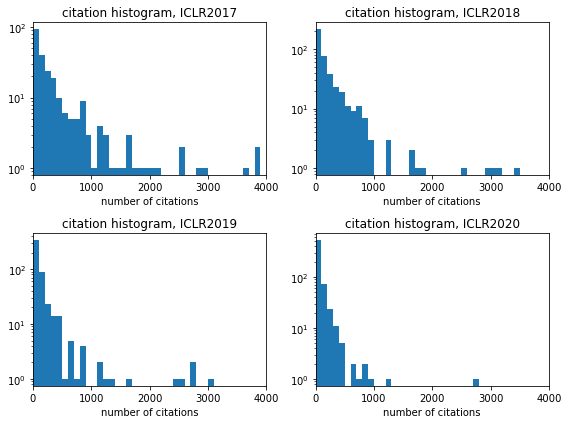

In [214]:
plt.figure(figsize=(8, 6))
for idx, df in enumerate(dfs):
    plt.subplot(2,2, idx+1)
    bins = np.arange(0, 5000, 100)
    plt.hist(df.citations, bins, )
    plt.xlabel("number of citations")
    plt.title(f"citation histogram, ICLR{names[idx]}")
    plt.xlim(0, 4000)
    plt.yscale('log')
plt.tight_layout()
plt.show()


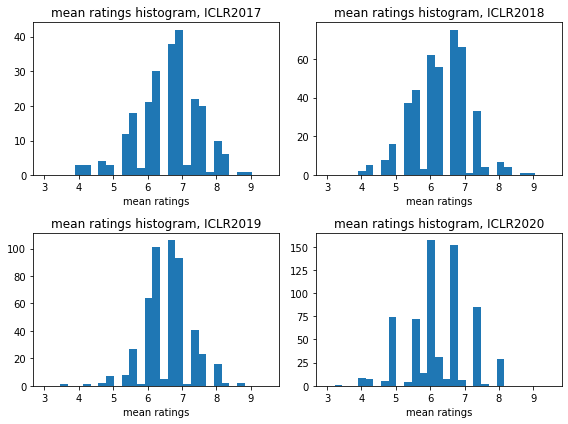

In [215]:
plt.figure(figsize=(8, 6))
for idx, df in enumerate(dfs):
    plt.subplot(2,2, idx+1)
    bins = np.linspace(3, 9.5, 30)
    plt.hist(df.mean_rating, bins=bins)
    plt.xlabel("mean ratings")
    plt.title(f"mean ratings histogram, ICLR{names[idx]}")
#     plt.xlim(0, 4000)
plt.tight_layout()
plt.show()


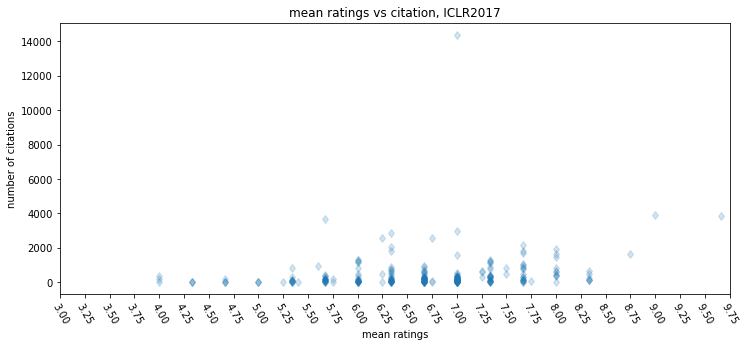

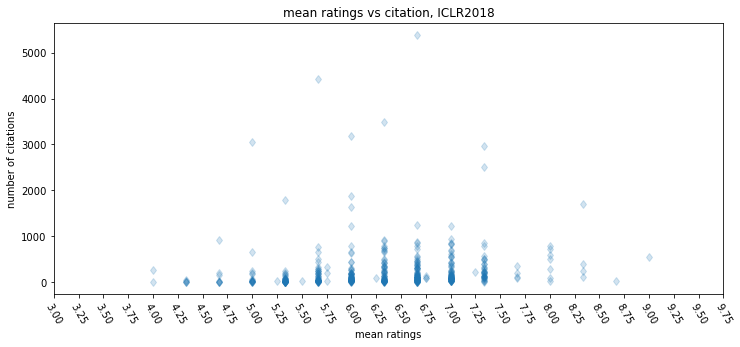

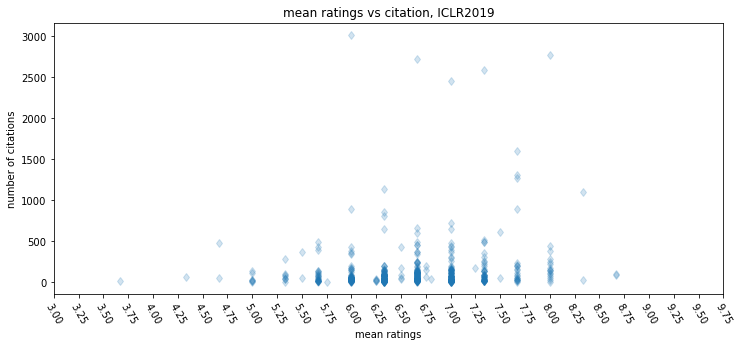

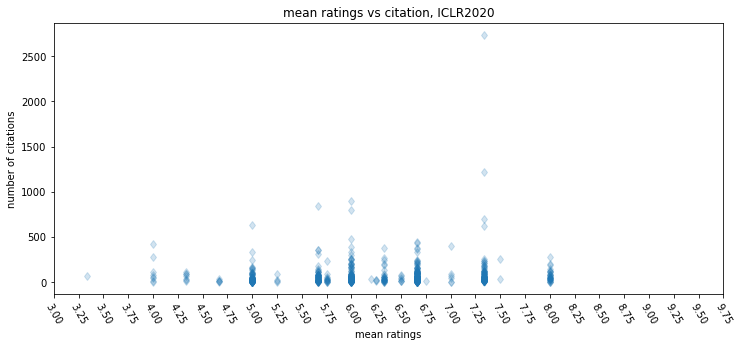

In [216]:

for idx, df in enumerate(dfs):
#     plt.subplot(2,2, idx+1)
    plt.figure(figsize=(12, 5))
    plt.plot(df.mean_rating, df.citations, 'd', alpha=0.2)
    plt.xlabel("mean ratings")
    plt.ylabel("number of citations")
    plt.title(f"mean ratings vs citation, ICLR{names[idx]}")
    plt.xlim(3.2, 9.2)
    plt.xticks(np.arange(3, 10, 0.25), rotation=-60)



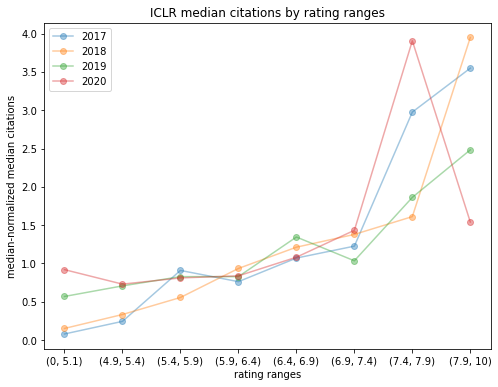

In [217]:
binning_list = [(0, 5.1), (4.9, 5.4), (5.4, 5.9), (5.9, 6.4), (6.4, 6.9), (6.9, 7.4), (7.4, 7.9), (7.9, 10)]
plt.figure(figsize=(8, 6))
for idx, df in enumerate(dfs):
    
    df_by_chunk = get_binned_df_list(df, binning_list)
    median_citations = [np.median(x.citations) for x in df_by_chunk]
    plt.plot(np.array(median_citations) / np.median(df.citations), "o-", label=names[idx], alpha=0.4)
    plt.xticks(range(8), binning_list)
    
plt.title("ICLR median citations by rating ranges")
plt.legend()
plt.ylabel("median-normalized median citations")
plt.xlabel("rating ranges")
plt.show()

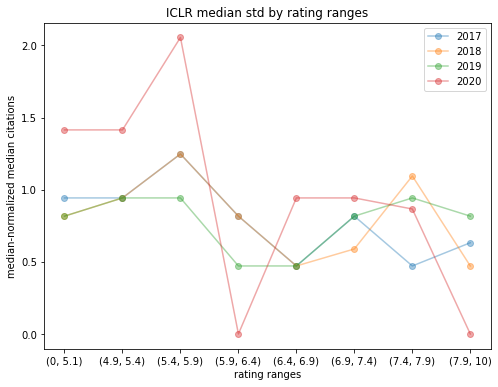

In [218]:
binning_list = [(0, 5.1), (4.9, 5.4), (5.4, 5.9), (5.9, 6.4), (6.4, 6.9), (6.9, 7.4), (7.4, 7.9), (7.9, 10)]
plt.figure(figsize=(8, 6))

for idx, df in enumerate(dfs):
    
    df_by_chunk = get_binned_df_list(df, binning_list)
    median_std = [np.median(np.sqrt(x.var_rating)) for x in df_by_chunk]
    plt.plot(np.array(median_std), "o-", label=names[idx], alpha=0.4)
    plt.xticks(range(8), binning_list)
    
plt.title("ICLR median std by rating ranges")
plt.legend()
plt.ylabel("median-normalized median citations")
plt.xlabel("rating ranges")
plt.show()

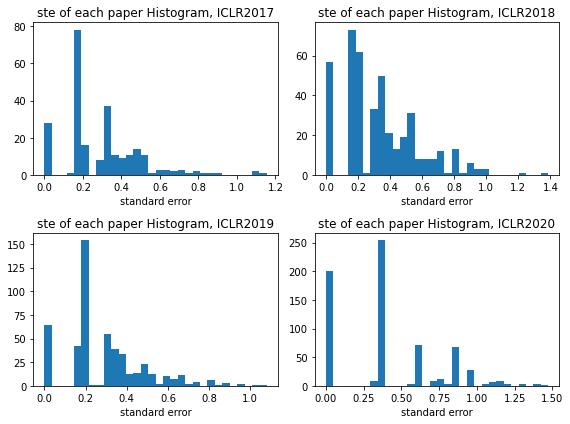

In [197]:
plt.figure(figsize=(8, 6))
for idx, df in enumerate(dfs):
    plt.subplot(2,2, idx+1)
#     bins = np.linspace(3, 9.5, 30)
    standard_error = np.sqrt(df.var_rating) / np.sqrt(df.mean_rating)
    plt.hist(standard_error, bins=30)
    plt.xlabel("standard error")
    plt.title(f"ste of each paper Histogram, ICLR{names[idx]}")
#     plt.xlim(0, 4000)
plt.tight_layout()
plt.show()


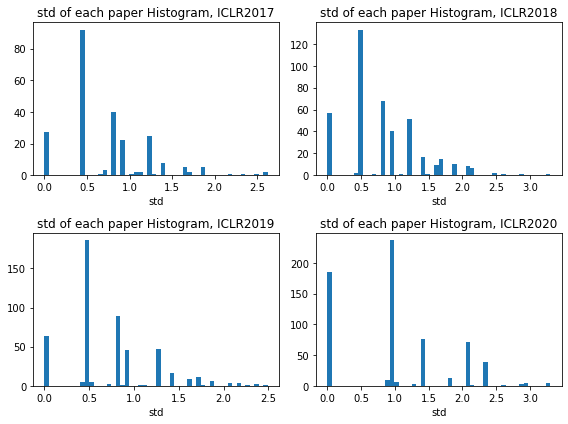

In [219]:
plt.figure(figsize=(8, 6))
for idx, df in enumerate(dfs):
    plt.subplot(2,2, idx+1)
#     bins = np.linspace(3, 9.5, 30)
    std = np.sqrt(df.var_rating)
    plt.hist(std, bins=50)
    plt.xlabel("std")
    plt.title(f"std of each paper Histogram, ICLR{names[idx]}")
#     plt.xlim(0, 4000)
plt.tight_layout()
plt.show()


In [201]:
std_ranges = [(-0.1,0.25), (0.25,0.75), (0.25,0.75),  (0.75,1.25),  (1.25,1.75),(1.75, 5)]